<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/bernoulli_hmm_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bernoulli HMM Example Notebook

Modified from https://github.com/lindermanlab/ssm-jax-refactor/blob/main/notebooks/bernoulli-hmm-example.ipynb



In [2]:
#!pip install -qq  git+git://github.com/lindermanlab/ssm-jax-refactor.git

In [3]:
try:
    import ssm
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/lindermanlab/ssm-jax.git
    import ssm

#### Imports and Plotting Functions 

In [4]:
import jax.random as jr
import jax.numpy as np
import matplotlib.pyplot as plt

try:
    from tensorflow_probability.substrates import jax as tfp
except ModuleNotFoundError:
    %pip install -qq tensorflow-probability
    from tensorflow_probability.substrates import jax as tfp

try:
    from ssm.hmm import BernoulliHMM
except ModuleNotFoundError:
    %pip install -qq ssm
    from ssm.hmm import BernoulliHMM
from ssm.plots import gradient_cmap
from ssm.utils import find_permutation
import warnings

import seaborn as sns

sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue", "red", "amber", "faded green", "dusty purple", "orange"]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


def plot_transition_matrix(transition_matrix):
    plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
    plt.xlabel("next state")
    plt.ylabel("current state")
    plt.colorbar()
    plt.show()


def compare_transition_matrix(true_matrix, test_matrix):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    out = axs[0].imshow(true_matrix, vmin=0, vmax=1, cmap="Greys")
    axs[1].imshow(test_matrix, vmin=0, vmax=1, cmap="Greys")
    axs[0].set_title("True Transition Matrix")
    axs[1].set_title("Test Transition Matrix")
    cax = fig.add_axes(
        [
            axs[1].get_position().x1 + 0.07,
            axs[1].get_position().y0,
            0.02,
            axs[1].get_position().y1 - axs[1].get_position().y0,
        ]
    )
    plt.colorbar(out, cax=cax)
    plt.show()


def plot_hmm_data(obs, states):
    lim = 1.01 * abs(obs).max()
    time_bins, obs_dim = obs.shape
    plt.figure(figsize=(8, 3))
    plt.imshow(
        states[None, :],
        aspect="auto",
        cmap=cmap,
        vmin=0,
        vmax=len(colors) - 1,
        extent=(0, time_bins, -lim, (obs_dim) * lim),
    )

    for d in range(obs_dim):
        plt.plot(obs[:, d] + lim * d, "-k")

    plt.xlim(0, time_bins)
    plt.xlabel("time")
    plt.yticks(lim * np.arange(obs_dim), ["$x_{}$".format(d + 1) for d in range(obs_dim)])

    plt.title("Simulated data from an HMM")

    plt.tight_layout()


def plot_posterior_states(Ez, states, perm):
    plt.figure(figsize=(25, 5))
    plt.imshow(Ez.T[perm], aspect="auto", interpolation="none", cmap="Greys")
    plt.plot(states, label="True State")
    plt.plot(Ez.T[perm].argmax(axis=0), "--", label="Predicted State")
    plt.xlabel("time")
    plt.ylabel("latent state")
    # plt.legend(bbox_to_anchor=(1,1))
    plt.title("Predicted vs. Ground Truth Latent State")
    # plt.show()

# Bernoulli HMM

### Let's create a true model

In [5]:
num_states = 5
num_channels = 10

transition_matrix = 0.90 * np.eye(num_states) + 0.10 * np.ones((num_states, num_states)) / num_states

true_hmm = BernoulliHMM(
    num_states, num_emission_dims=num_channels, transition_matrix=transition_matrix, seed=jr.PRNGKey(0)
)

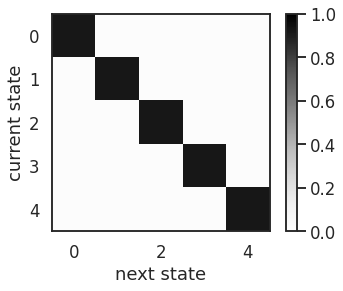

In [6]:
plot_transition_matrix(true_hmm.transition_matrix)

### From the true model, we can sample synthetic data

In [7]:
rng = jr.PRNGKey(0)
num_timesteps = 500

states, data = true_hmm.sample(rng, num_timesteps)

### Let's view the synthetic data

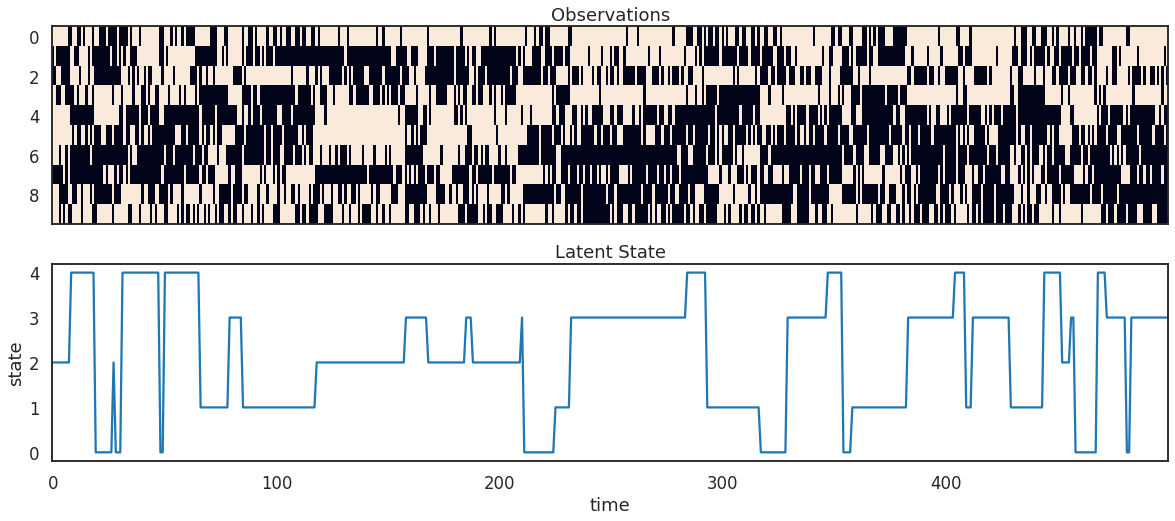

In [8]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 8))
axs[0].imshow(data.T, aspect="auto", interpolation="none")
# axs[0].set_ylabel("neuron")
axs[0].set_title("Observations")
axs[1].plot(states)
axs[1].set_title("Latent State")
axs[1].set_xlabel("time")
axs[1].set_ylabel("state")

plt.savefig("bernoulli-hmm-data.pdf")
plt.savefig("bernoulli-hmm-data.png")
plt.show()

## Fit HMM using exact EM update

In [9]:
test_hmm = BernoulliHMM(num_states, num_channels, seed=jr.PRNGKey(32))
lps, test_hmm, posterior = test_hmm.fit(data, method="em", tol=-1)

Initializing...
Done.


  0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, 'log likelihood')

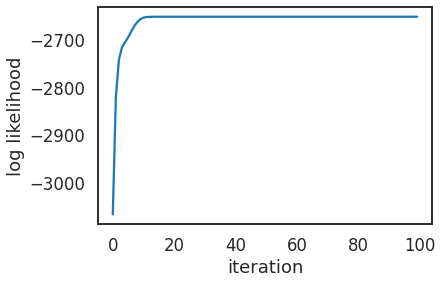

In [10]:
# Plot the log probabilities
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log likelihood")

In [11]:
test_hmm.transition_matrix

DeviceArray([[0.93613327, 0.0097205 , 0.01064173, 0.01220589, 0.03129863],
             [0.00111887, 0.93961614, 0.02881143, 0.00132547, 0.02912819],
             [0.05014141, 0.00170274, 0.8506949 , 0.06562589, 0.03183506],
             [0.02687715, 0.00188023, 0.0730443 , 0.8491525 , 0.04904585],
             [0.01370139, 0.02004755, 0.02332069, 0.00975819, 0.9331721 ]],            dtype=float32)

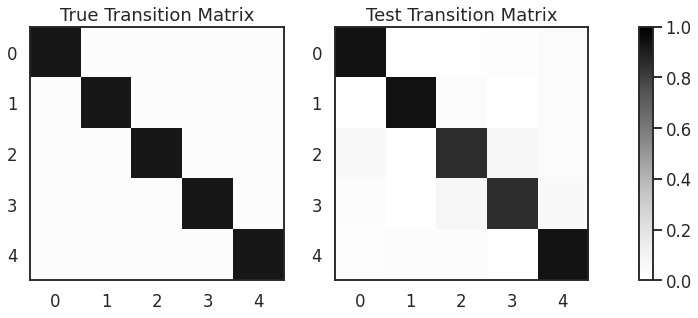

<Figure size 432x288 with 0 Axes>

In [12]:
# Compare the transition matrices
compare_transition_matrix(true_hmm.transition_matrix, test_hmm.transition_matrix)
plt.savefig("bernoulli-hmm-transmat-comparison.pdf")

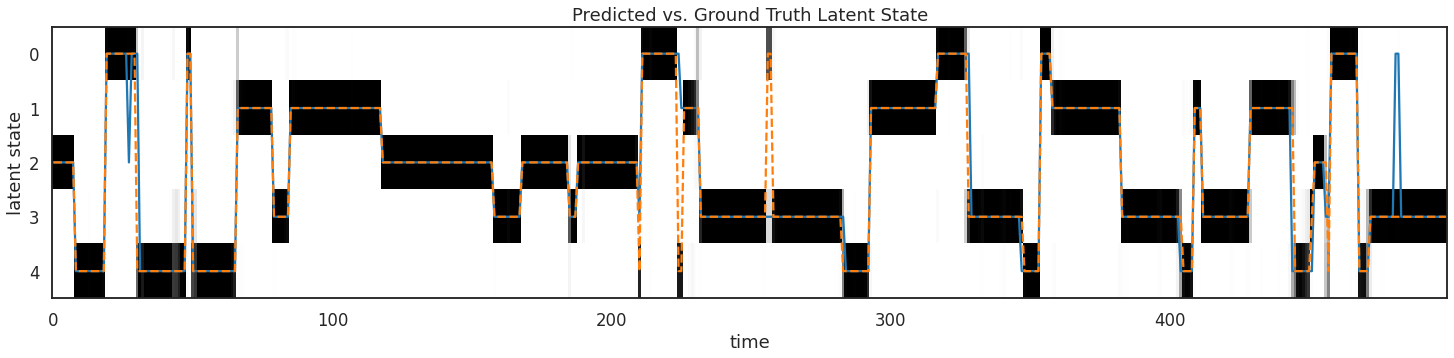

In [13]:
# Posterior distribution
Ez = posterior.expected_states.reshape(-1, num_states)
perm = find_permutation(states, np.argmax(Ez, axis=-1))
plot_posterior_states(Ez, states, perm)

plt.savefig("bernoulli-hmm-state-est-comparison.pdf")
plt.savefig("bernoulli-hmm-state-est-comparison.png")
plt.show()

# Fit Bernoulli Over Multiple Trials

In [14]:
rng = jr.PRNGKey(0)
num_timesteps = 500
num_trials = 5

all_states, all_data = true_hmm.sample(rng, num_timesteps, num_samples=num_trials)

In [15]:
# Now we have a batch dimension of size `num_trials`
print(all_states.shape)
print(all_data.shape)

(5, 500)
(5, 500, 10)


In [16]:
lps, test_hmm, posterior = test_hmm.fit(all_data, method="em", tol=-1)

Initializing...
Done.


  0%|          | 0/100 [00:00<?, ?it/s]

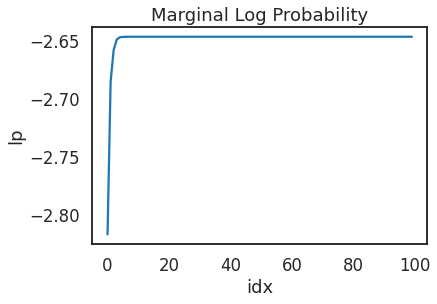

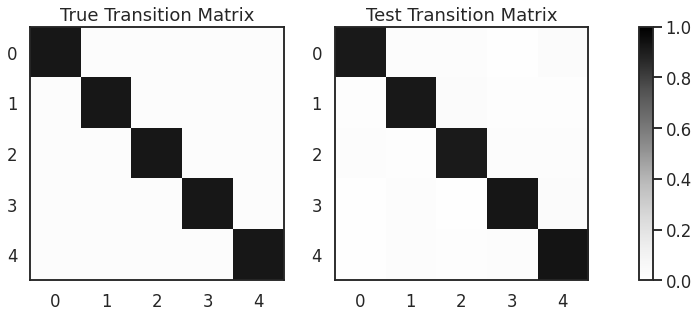

In [17]:
# plot marginal log probabilities
plt.title("Marginal Log Probability")
plt.ylabel("lp")
plt.xlabel("idx")
plt.plot(lps / data.size)

compare_transition_matrix(true_hmm.transition_matrix, test_hmm.transition_matrix)

===== Trial: 0 =====
===== Trial: 1 =====
===== Trial: 2 =====


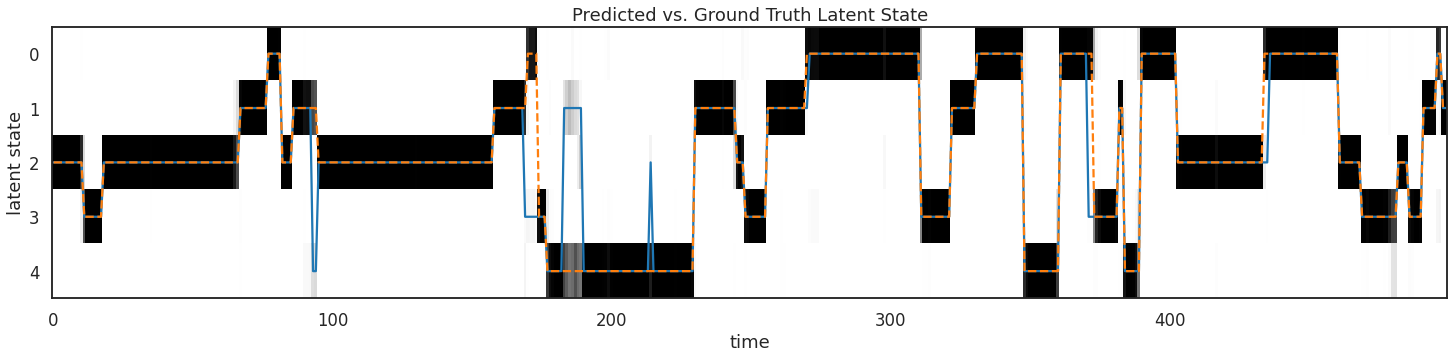

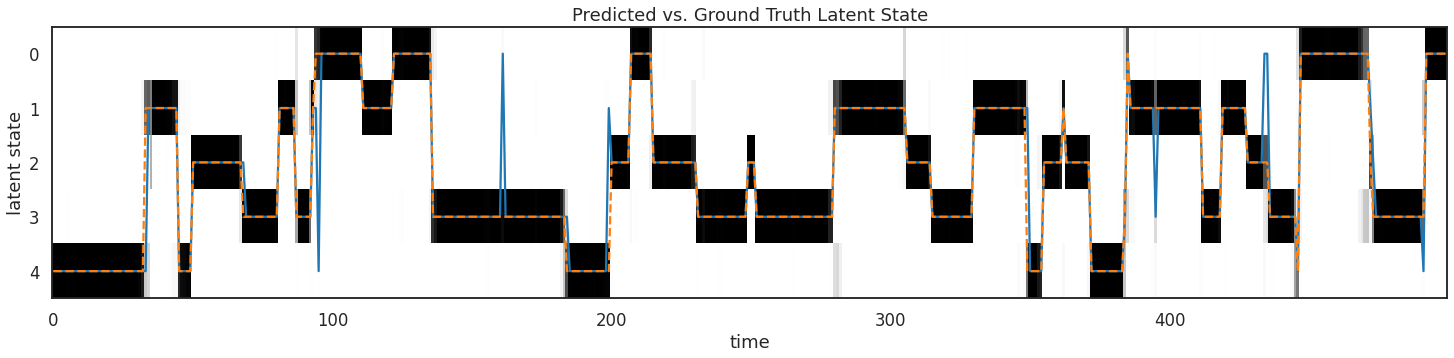

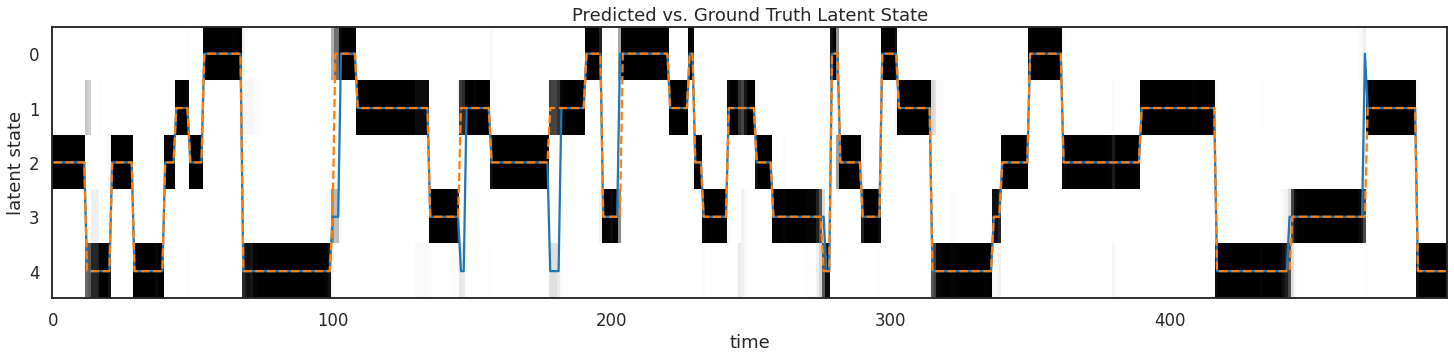

In [18]:
# For the first few trials, let's see how good our predicted states are
for trial_idx in range(3):
    print("=" * 5, f"Trial: {trial_idx}", "=" * 5)
    Ez = posterior.expected_states[trial_idx]
    states = all_states[trial_idx]
    perm = find_permutation(states, np.argmax(Ez, axis=-1))
    plot_posterior_states(Ez, states, perm)